## Make detailed maps with HUC2 boundaries  
_DTT, adapted from Yueling Ma_  
  
This notebook creates figures of data mapped over HUC2 and country boundaries. The resulting figure is a scatter plot of data by latitude and longitude with a variable specified for the color of the scatter plot.  

Inputs:
- CSV of data to be plotted. As of now, this mainly comes from previous scripts that calculate stats on PFCLM variables compared to observations (e.g., `compare_SNOTEL_temp.ipynb` or `2_SaveStreamflowStats.ipynb`)
- User defined inputs (water year, plot names and variables, corner lat/long for bounding box)
- Already defined here, but worth checking the file paths:
  -  CONUS2 lat and long files (`Latitude_CONUS2.pfb`, `Longitude_CONUS2.pfb`)
  -  CONUS2 HUC2 boundary tif file (`CONUS2.0.Final1km.Subbasin_HUC2.remapped.tif`)

In [95]:
#import sys
import numpy as np
import pandas as pd
from PIL import Image
#from pyproj import Proj, transform, CRS
# from osgeo import gdal
# from imagecodecs import imread

from parflow.tools.io import read_pfb

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# from matplotlib.colors import ListedColormap
#import matplotlib.cm as cm
# import matplotlib


##### CSV paths just for ease of use
Streamflow: `'/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/Streamflow/\
Organized_Daily_Flow/Summary_Gages_CONUS2_WY2003.csv'`  

`'/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/SNOTEL/\
precip_temp/Organized_csv/precip/Summary_Stations_CONUS2_SNOTEL_Precip_tot_WY2003.csv'`

In [2]:
water_year = 2003

In [111]:
# CSV of saved data that will be plotted
data_csv_path = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/Streamflow/\
Organized_Daily_Flow/Summary_Gages_CONUS2_WY2003.csv'
stats_df = pd.read_csv(data_csv_path)
# check the data you loaded
stats_df.head()

,site_id,latitude,longitude,conus2_x,conus2_y,USGS_mean_cms,PF_mean_cms,absrelbias,bias,pbias,srho,mse,rmse,r2
0,1011000,47.069722,-69.079444,4210,2783,41.836549,29.714315,0.289752,-0.289752,-28.975225,0.706543,0.0,0.0,0.598717
1,1013500,47.237500,-68.582778,4237,2810,39.405556,18.607378,0.527798,-0.527798,-52.779810,0.517411,0.0,0.0,0.220357
2,1015800,46.523056,-68.371667,4276,2747,33.593030,27.100917,0.193258,-0.193258,-19.325775,0.816297,0.0,0.0,0.563045
3,1017000,46.777222,-68.157222,4281,2773,66.854292,58.205067,0.129374,-0.129374,-12.937427,0.708347,0.0,0.0,0.623226
4,1017550,46.628056,-67.953056,4300,2762,0.142967,0.063122,0.558483,-0.558483,-55.848308,0.364924,0.0,0.0,-0.243661


In [112]:
### Here, define everything specific to the plot variables
### This includes: 
### - directory where plots are saved to (plot_dir)
### - variable you want to plot as a color in the scatter plot (plot_var)
### - plot title to be displayed on plot (plot_title)
### - name to save plot file as (plot_to_save)


## location where plots are being saved ##
plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Streamflow/'
#plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/SNOTEL/precip_temp/Figures/summary_plots_precip'

## Variable you want to plot (this will show up as the scatter plot colormap) ##
plot_var = stats_df['bias']

## Plot title ##
plot_title = f'WY{water_year} PFCONUS2 Streamflow Relative Bias'
#plot_title = f'WY{water_year} CW3E vs SNOTEL Precip Relative Bias'

## Name of file for plot to save ##
plot_to_save = f'PFCONUS2_streamflow_RelBias_Map_WY{water_year}_WesternUSMap.png'#HUC2boundaries.png'
#plot_to_save = f'CW3E_SNOTEL_precip_WY{water_year}_RelBias_WesternUSMap.png'

print(f'Figure will be saved as: {plot_to_save}')
print(f'in the directory: {plot_dir}')

Figure will be saved as: PFCONUS2_streamflow_RelBias_Map_WY2003_WesternUSMap.png
in the directory: /hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Streamflow/


In [113]:
#### define longitude and latitude corner boundaries for map bounds in Basemap 
# CONUS2: ur_lat = 49, ur_lon = -64, ll_lat = 22, ll_lon = -119 (this cuts part of the Columbia R Basin now)
# CONUS2: central_lon = -95, no central latitude

ll_lon = -123
ll_lat = 30
ur_lon = -102
ur_lat = 50
# central lat and long, good for if you want to zoom in on an area (e.g. western US)
central_lat = 40
central_lon = -111

_________________
#### Below this, user can make changes to the script (such as changing the colormap, vmin & vmax, or other figure details), but shouldn't need to if everything above is correct.  
_________________

In [109]:
#CONUS2 coordinates 
lats_CONUS2 = np.squeeze(read_pfb('/hydrodata/national_mapping/CONUS2/Latitude_CONUS2.pfb'),axis=0)
lons_CONUS2 = np.squeeze(read_pfb('/hydrodata/national_mapping/CONUS2/Longitude_CONUS2.pfb'),axis=0)

huc2_tif = '/hydrodata/national_mapping/CONUS2/CONUS2.0.Final1km.Subbasin_HUC2.remapped.tif'

# open HUC2 tif
im = Image.open(huc2_tif) 
# make HUC2 tif into numpy array
imarray = np.array(im) 
print(f'Domain dimensions of tif array: {imarray.shape}')
# make tif correct orientation (flip vertically)
tiff_numpy = np.flipud(imarray)

Domain dimensions of tif array: (3256, 4442)


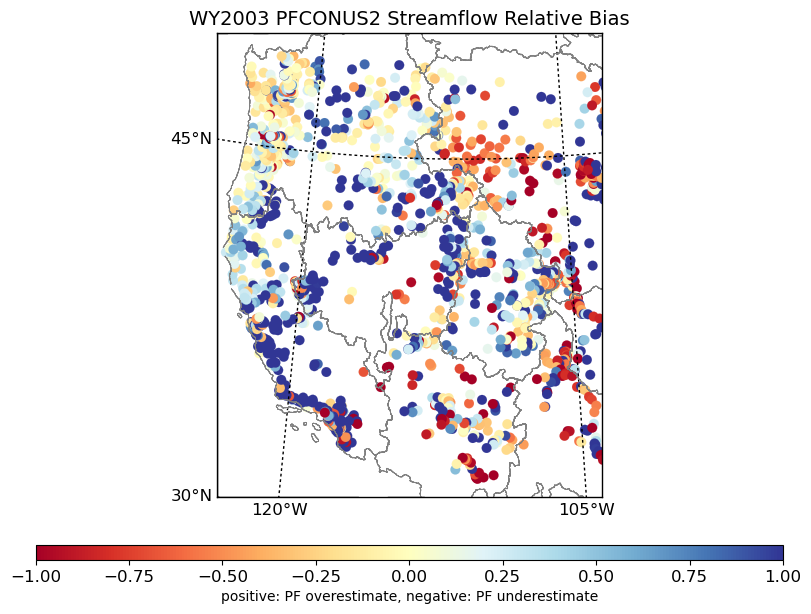

In [115]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6),constrained_layout=True)

# these lat/long coordinates are boundaries of map to visualize (defined above) 
m1 = Basemap(llcrnrlon=ll_lon,llcrnrlat=ll_lat,urcrnrlon=ur_lon,urcrnrlat=ur_lat,\
             projection='lcc',lat_1=33,lat_2=45,lon_0=central_lon, lat_0 = central_lat, ax=ax1)


#point coordinates for what is being mapped
lons1, lats1 = m1(stats_df.longitude,stats_df.latitude)

lons_basin, lats_basin = m1(lons_CONUS2,lats_CONUS2)

##Draw coastlines & countries
#m1.drawcoastlines(color='k',linewidth=0.8)
#m1.drawcountries(color='k',linewidth=0.8)

#Draw parallels and meridians
m1.drawparallels(np.arange(-90.,91.,15.),labels=[True,False,False,False],dashes=[2,2],fontsize=12)
m1.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True],dashes=[2,2],fontsize=12)

m1.fillcontinents(color='white',lake_color='white')
m1.drawmapboundary(fill_color='white')

im1 = m1.scatter(lons1,lats1,c=plot_var,s=50,linewidths=0.1,cmap='RdYlBu',vmin = -1, vmax = 1)#,alpha=.9

ax1.set_title(plot_title,fontsize=14) 

cbar1 = plt.colorbar(im1,ax=ax1,shrink=1,aspect=50,orientation='horizontal',\
                     label = 'positive: PF overestimate, negative: PF underestimate')#,
cbar1.ax.tick_params(labelsize=12)

#Draw river basins
for water_basin_index in range(1,19):
    mask_index = np.where(tiff_numpy==water_basin_index)
    mask_arr = np.zeros([tiff_numpy.shape[0],tiff_numpy.shape[1]])
    mask_arr[mask_index] = 1
    
    m1.contour(lons_basin,lats_basin,mask_arr,colors='grey',linewidths=0.5)

plt.savefig(f'{plot_dir}/{plot_to_save}',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

plt.show()

### Plots using png of CONUS2 HUC map (alternative to the above method)

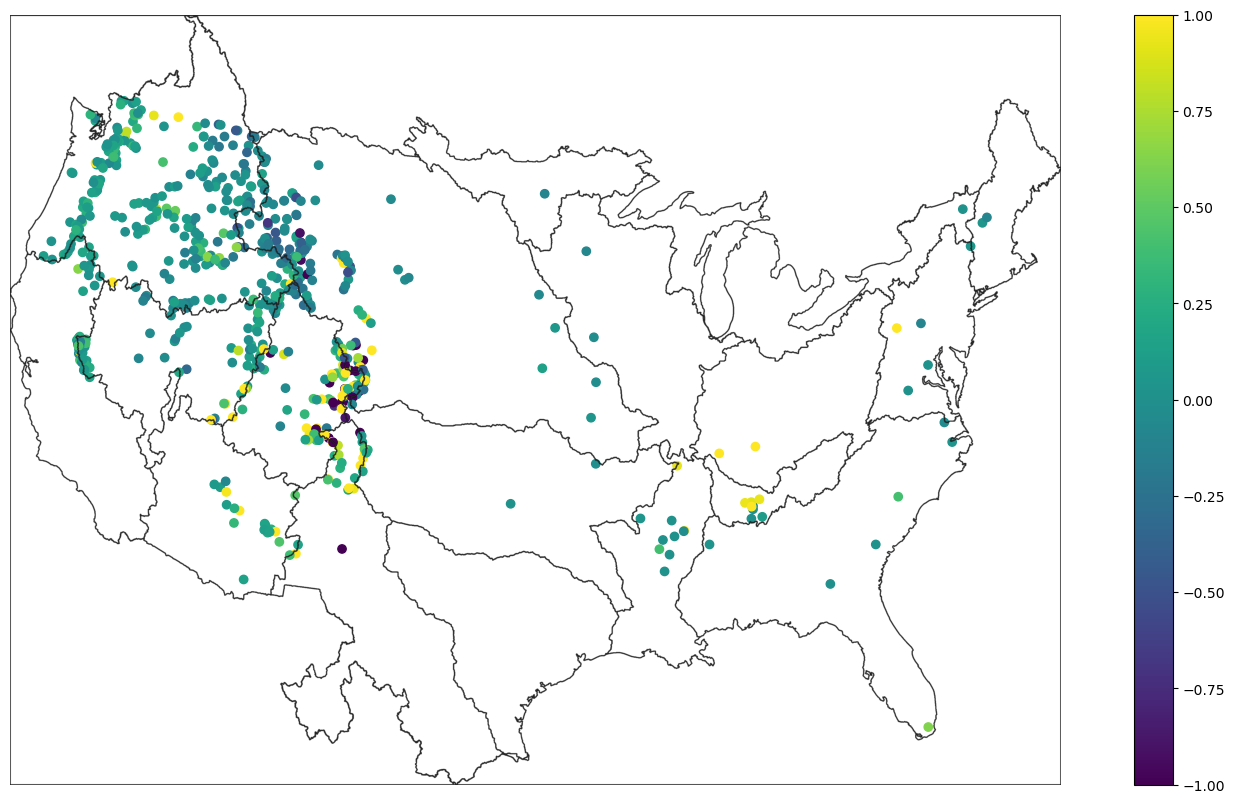

In [76]:
#Plotting over an image of the CONUS domain
import numpy as np
from matplotlib import pyplot as plt
#plt.rcParams["figure.figsize"] = [7.00, 3.50]
#plt.rcParams["figure.autolayout"] = True
im = plt.imread("CONUS2_outline_with_HUC2.png")
fig, ax = plt.subplots(1,1,figsize=(19,10))
im = ax.imshow(im, extent=[0, 4442, 0, 3256],zorder=2)
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.bias, vmax = 1, vmin = -1, zorder=1)
plt.colorbar(points)
plt.axis('off')

plt.show()

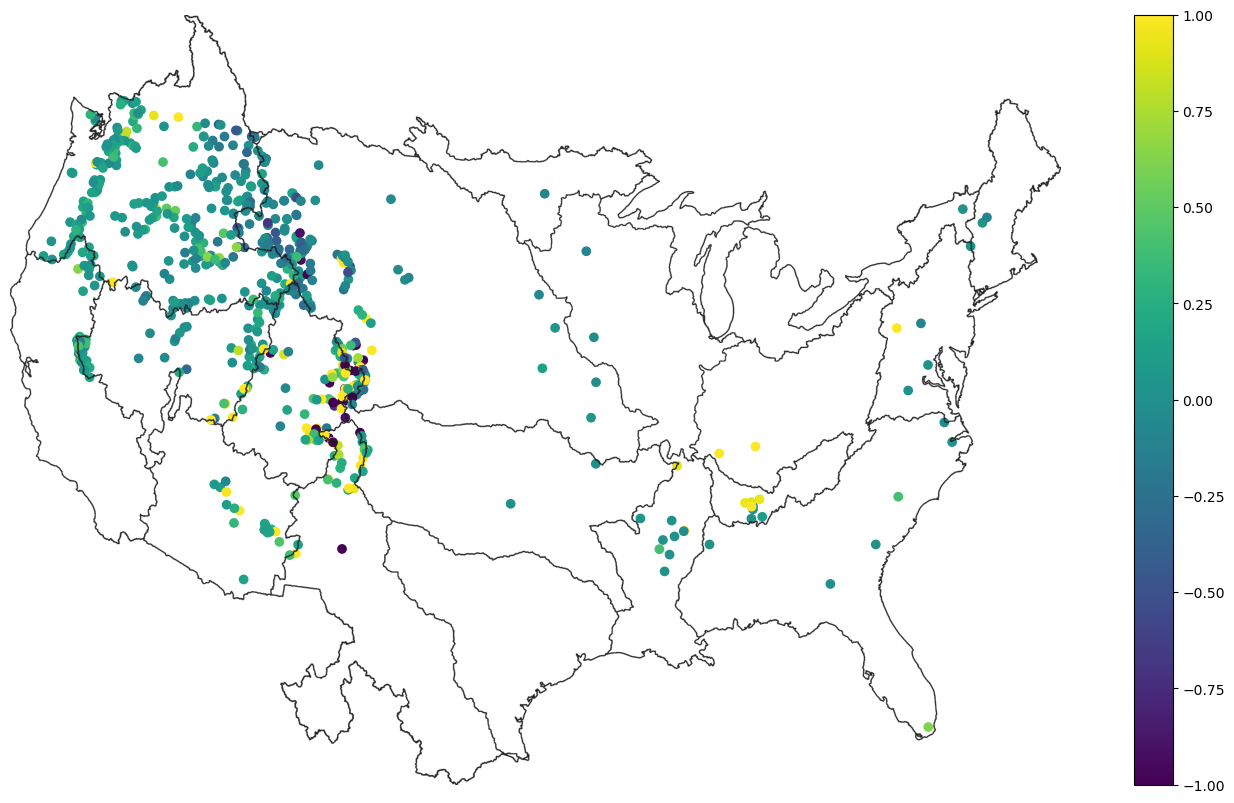

In [77]:
#Plotting over an image of the CONUS domain
import numpy as np
from matplotlib import pyplot as plt
#plt.rcParams["figure.figsize"] = [7.00, 3.50]
#plt.rcParams["figure.autolayout"] = True
im = plt.imread("CONUS2_outline_with_HUC2_noSqrBorder.png")
fig, ax = plt.subplots(1,1,figsize=(19,10))
im = ax.imshow(im, extent=[0, 4442, 0, 3256],zorder=2)
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.bias, vmax = 1, vmin = -1, zorder=1)
plt.colorbar(points)
plt.axis('off')

plt.show()